In [1]:
# standard libraries
import numpy as np #numpy warnings may be safely ignored, known issue.
import pandas as pd
from collections import defaultdict
from math import * # Used for the haversine/distance calculations
import datetime as dt 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for model building
from sklearn.cluster import KMeans

# for optimizations
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Make an empty DefaultDict
# fill dictionary {year: station data}
# build hierarchal dataframe using dictionary

# Example of data location
# https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2010/NiceRide_station_2010.csv

nr_dict = defaultdict()
for x in [2010 + x for x in range(8)] :
    nr_dict[x] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                             +str(x)+"/NiceRide_station_"+str(x)+".csv")
nr_station = pd.concat(nr_dict)

In [3]:
# Extracting the most robust year/data set from the total
nr_station_2017 = nr_station.loc[(2017),:]

In [4]:
nr_station_2017.tail()

,Terminal,Station,Latitude,Longitude,Ndocks
196,30199,Hidden Falls Park,44.907001,-93.191432,19
197,30201,Elwood Ave N & Oak Park Ave N,44.987160,-93.301944,15
198,30202,Mill City Quarter,44.980500,-93.261800,23
199,30203,W 50th Street & W Minnehaha Pkwy,44.912125,-93.298552,23
200,30204,NE Central Ave & NE 14th Ave,45.002526,-93.247162,15


## First we'll create a matrix that has the arc distance of each station comparatively.

In [5]:
station_ids = nr_station_2017.Terminal.values # will be used for matrix column names

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    '''
    Haversine definition: will calculate the distance between two points
    using the latitude and longitude of each point.
    '''
    miles_constant = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    mi = miles_constant * c
    return mi

In [7]:
distance = pd.DataFrame(index = station_ids)
for x in range(len(station_ids)) :
    distance[station_ids[x]] = haversine(nr_station_2017.Latitude.values[x], nr_station_2017.Longitude.values[x],\
                            nr_station_2017.Latitude.values, nr_station_2017.Longitude.values)

In [8]:
distance_matrix = np.array(distance.iloc[:,:])

In [9]:
distance.info()
distance.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 30000 to 30204
Columns: 201 entries, 30000 to 30204
dtypes: float64(201)
memory usage: 317.2 KB


,30000,30001,30002,30003,30004,30005,30006,30007,30008,30009,...,30194,30195,30196,30197,30198,30199,30201,30202,30203,30204
30000,0.000000,2.500883,1.466835,2.471107,1.267481,0.304709,1.308283,1.034074,2.514716,0.970652,...,1.792963,1.091036,1.346930,1.120933,0.944879,6.253741,2.223943,0.397380,5.431379,1.301979
30001,2.500883,0.000000,1.062434,4.686271,2.976568,2.642299,2.790346,2.456370,1.899581,1.775162,...,1.178669,1.412001,1.362179,1.653395,1.579928,3.813231,4.358510,2.467683,4.825362,3.331634
30002,1.466835,1.062434,0.000000,3.641812,1.967888,1.648298,1.808542,1.448112,1.612348,0.969751,...,0.977645,0.389264,0.738530,0.920689,0.633325,4.788731,3.322895,1.405513,4.753667,2.470703
30003,2.471107,4.686271,3.641812,0.000000,1.746448,2.564107,1.971116,2.246913,3.718459,3.438583,...,4.236012,3.364533,3.782869,3.585482,3.330279,8.096739,0.361928,2.300340,5.491521,2.988440
30004,1.267481,2.976568,1.967888,1.746448,0.000000,1.530430,0.242315,0.521591,2.057588,2.053101,...,2.722854,1.761634,2.284861,2.171021,1.813986,6.364891,1.399569,0.899256,4.474715,2.429523


In [10]:
# If we wanted to merge our two new dataframes together
# nr_station_2017 = pd.merge(nr_station_2017, distance, left_on='Terminal', right_index=True)

## Create a csv of this matrix for faster runs
pd.to_csv()

In [11]:
distance_matrix

array([[ 0.        ,  2.50088312,  1.46683481, ...,  0.39738012,
         5.43137926,  1.30197948],
       [ 2.50088312,  0.        ,  1.06243441, ...,  2.46768258,
         4.82536183,  3.33163364],
       [ 1.46683481,  1.06243441,  0.        , ...,  1.40551251,
         4.7536674 ,  2.47070301],
       ..., 
       [ 0.39738012,  2.46768258,  1.40551251, ...,  0.        ,
         5.05488421,  1.68165967],
       [ 5.43137926,  4.82536183,  4.7536674 , ...,  5.05488421,
         0.        ,  6.73294638],
       [ 1.30197948,  3.33163364,  2.47070301, ...,  1.68165967,
         6.73294638,  0.        ]])

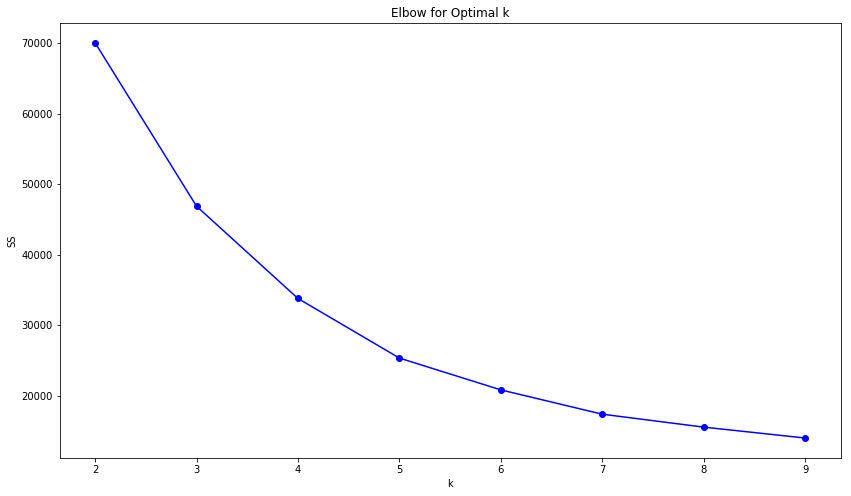

In [12]:
SS = []

# k means determine k
for k in range(2,10) :
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)

    SS.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(14,8))
plt.plot(range(2,10), SS, 'bo-')
plt.xlabel('k')
plt.ylabel('SS')
plt.title('Elbow for Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.654991890847
For n_clusters = 3 The average silhouette_score is : 0.559520976819
For n_clusters = 4 The average silhouette_score is : 0.391653116493
For n_clusters = 5 The average silhouette_score is : 0.440908685746
For n_clusters = 6 The average silhouette_score is : 0.466344575621
For n_clusters = 7 The average silhouette_score is : 0.450101999488
For n_clusters = 8 The average silhouette_score is : 0.429203540681
For n_clusters = 9 The average silhouette_score is : 0.415332533942


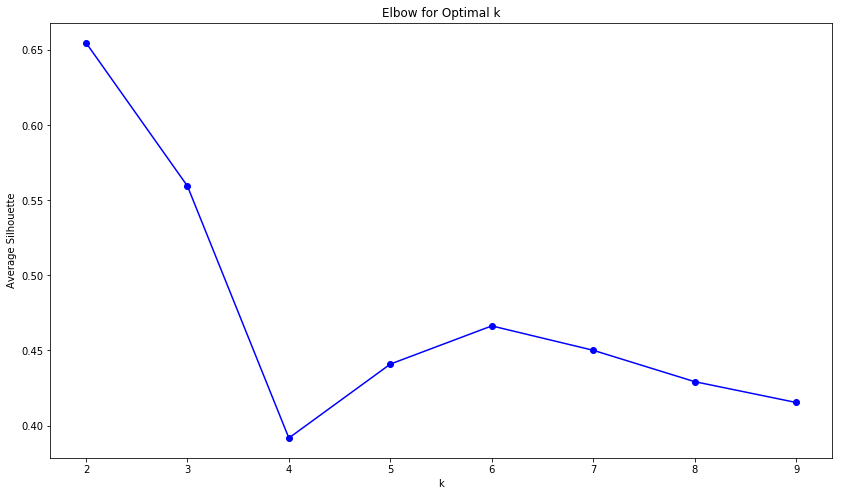

In [13]:
avg_sil = []

#    Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 10 clusters.
for k in range(2,10) :
    clusterer = KMeans(n_clusters=k, random_state=24).fit(distance_matrix)
    cluster_labels = clusterer.labels_
    
#    For each k, calculate the average silhouette of observations (avg.sil).
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    avg_sil.append(silhouette_avg)
    

#    Plot the curve of avg.sil according to the number of clusters k.
plt.figure(figsize=(14,8))
plt.plot(range(2,10), avg_sil, 'bo-')
plt.xlabel('k')
plt.ylabel('Average Silhouette')
plt.title('Elbow for Optimal k')
plt.show()
#    The location of the maximum is considered as the appropriate number of clusters.

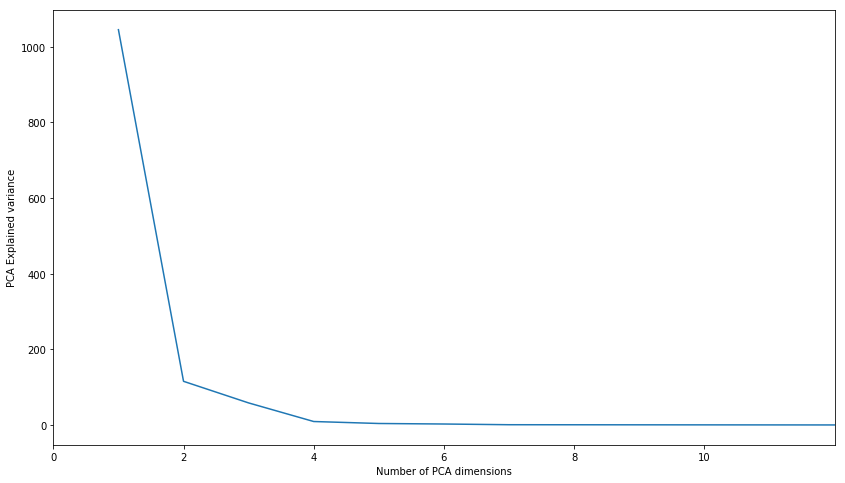

In [14]:
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(distance_matrix)

plt.figure(figsize=[14,8])
plt.xlim(0,12)
plt.plot(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xticks(range(0,12,2))
plt.ylabel('PCA Explained variance')
plt.xlabel('Number of PCA dimensions')
plt.show()

In [15]:
pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(distance_matrix), columns=['x','y'], index=nr_station_2017.index)
pca_df = pd.DataFrame(nr_station_2017.Terminal).join(pca_df)
    # Joins customer names to pca_df containing x-y PCA components
print(pca_df.head())

   Terminal          x          y
0     30000 -23.230553  -5.348980
1     30001  -4.544014 -14.150485
2     30002 -15.734367 -12.502557
3     30003 -21.637575  19.810301
4     30004 -26.821350   3.160106


The ideal dimensionality is 2, and KMeans cluster 6.

In [16]:
def kmeans_plot(pca_df, distance_matrix, x=4) :
    pca_df['cluster']= KMeans(n_clusters=x).fit(distance_matrix).labels_
    sns.lmplot(x='x', y='y', hue='cluster', data=pca_df, fit_reg=False, size=5)

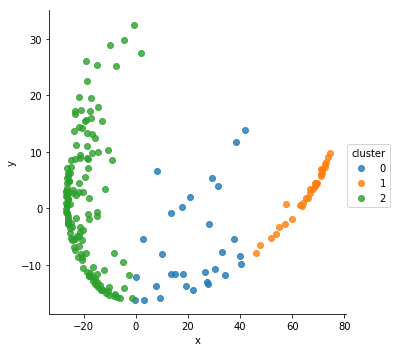

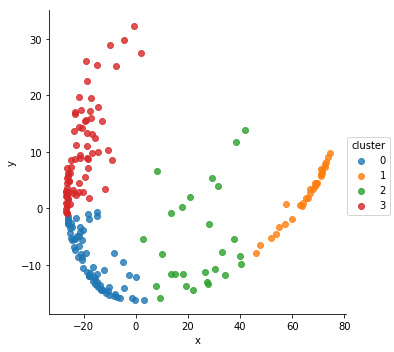

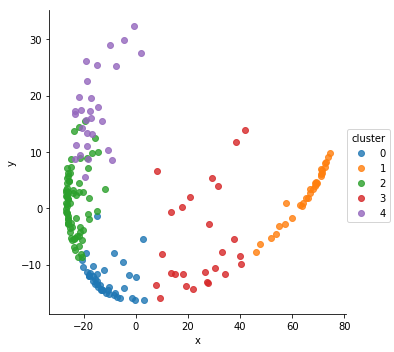

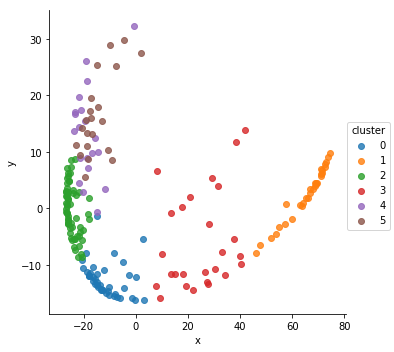

In [17]:
kmeans_plot(pca_df, distance_matrix, 3)
kmeans_plot(pca_df, distance_matrix, 4)
kmeans_plot(pca_df, distance_matrix, 5)
kmeans_plot(pca_df, distance_matrix, 6)

Looking at the graphs: 
* n_clusters=3 possibly over simplified
* n_clusters=4 possible insight
* n_clusters=5 possible insight
* n_clusters=6 possibly over-fitted

In [18]:
pca_df['cluster']= KMeans(n_clusters=4).fit(distance_matrix).labels_
four_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')
pca_df['cluster']= KMeans(n_clusters=5).fit(distance_matrix).labels_
five_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')
pca_df['cluster']= KMeans(n_clusters=6).fit(distance_matrix).labels_
six_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')

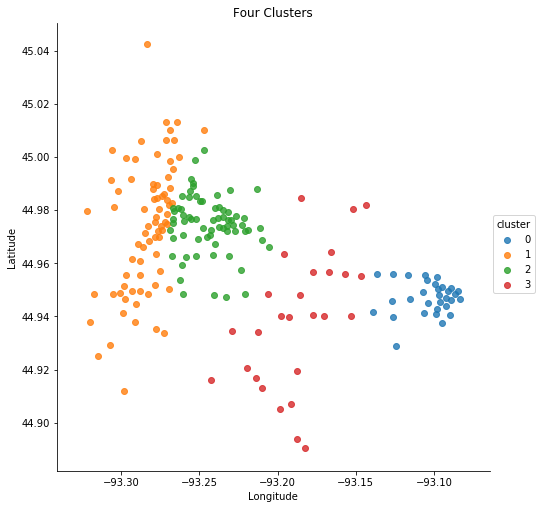

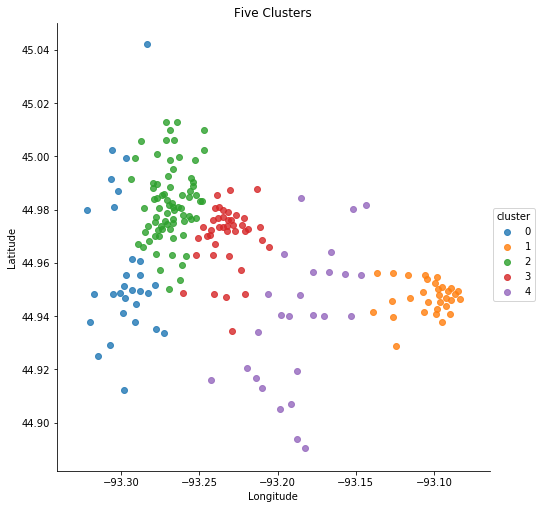

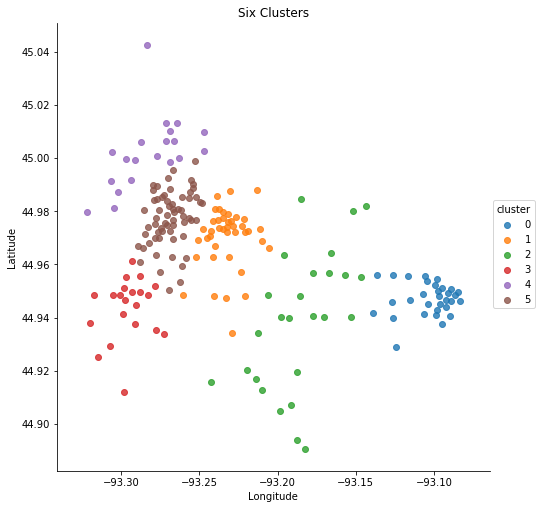

In [19]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=four_nr_clusters, fit_reg=False, size=7)
ax = plt.gca()
ax.set_title('Four Clusters')
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=five_nr_clusters, fit_reg=False, size=7)
ax = plt.gca()
ax.set_title('Five Clusters')
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)
ax = plt.gca()
ax.set_title('Six Clusters')

In [20]:
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,5
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,1
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,1
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,4
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,5


In [21]:
rides_2017 = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2017/NiceRide_trip_history_2017.csv")

In [22]:
rides_df = pd.DataFrame(rides_2017)

In [23]:
rides_df.info()
rides_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459903 entries, 0 to 459902
Data columns (total 8 columns):
Start_date    459903 non-null object
Start_name    459903 non-null object
Start_id      459903 non-null int64
End_date      459903 non-null object
End_name      459903 non-null object
End_id        459903 non-null int64
duration      459903 non-null int64
account       459903 non-null object
dtypes: int64(3), object(5)
memory usage: 28.1+ MB


,Start_date,Start_name,Start_id,End_date,End_name,End_id,duration,account
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,2017-11-05 22:02:00,Logan Park,30104,1048,Member
1,2017-11-05 21:45:00,Broadway Street N & 4th Street E,30122,2017-11-05 22:26:00,Broadway Street N & 4th Street E,30122,2513,Member
2,2017-11-05 21:43:00,Dale Street & Grand Ave.,30106,2017-11-05 22:13:00,N Milton Street & Summit Ave,30101,1817,Member
3,2017-11-05 21:41:00,Weisman Art Museum,30183,2017-11-05 22:05:00,22nd Ave S & Franklin Ave,30014,1399,Casual
4,2017-11-05 21:38:00,South 2nd Street & 3rd Ave S,30030,2017-11-05 21:44:00,6th Ave SE & University Ave,30088,370,Member


## Data prep/cleaning

In [24]:
# Adjusting the start and end date columns to datetime

rides_df['Start_date'] = rides_df['Start_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
rides_df['End_date'] = rides_df['End_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

## splitting based on (non-)member

In [25]:
member = rides_df[rides_df['account'] == "Member"]
casual = rides_df[rides_df['account'] != "Member"]

In [26]:
station_member = member[['Start_id', 'duration']]
station_member = station_member.groupby(['Start_id']).count()
station_member = station_member.rename(columns={'duration':'m_count'})

In [27]:
casual_member = casual[['Start_id', 'duration']]
casual_member = casual_member.groupby(['Start_id']).count()
casual_member = casual_member.rename(columns={'duration':'c_count'})

## Merging the data to our clustered dataframe

In [28]:
six_nr_clusters = pd.merge(six_nr_clusters, station_member, left_on='Terminal', right_index=True)
six_nr_clusters = pd.merge(six_nr_clusters, casual_member, left_on='Terminal', right_index=True)

In [29]:
temp = defaultdict()
for x in np.unique(six_nr_clusters.cluster.values) :
    temp['cluster_'+str(x)] = six_nr_clusters.groupby(six_nr_clusters.cluster==x)[['m_count', 'c_count']].describe()
cluster_describe = pd.concat(temp)
cluster_describe

m_count                                                    \
                    count         mean          std    min      25%     50%   
          cluster                                                             
cluster_0 False     170.0  1632.582353  1655.234018   61.0   465.75  1139.5   
          True       31.0   386.290323   224.764646  106.0   203.50   384.0   
cluster_1 False     160.0  1087.137500  1116.181059   61.0   315.25   722.0   
          True       41.0  2818.829268  2287.490130  460.0   960.00  1942.0   
cluster_2 False     175.0  1590.074286  1647.635498   61.0   437.00  1046.0   
          True       26.0   432.730769   321.685879   94.0   218.25   339.5   
cluster_3 False     180.0  1487.988889  1663.086701   61.0   349.50   891.0   
          True       21.0  1032.190476   559.938266  239.0   507.00   983.0   
cluster_4 False     181.0  1568.657459  1623.944609   94.0   454.00  1035.0   
          True       20.0   279.350000   182.466226   61.0   159.50   249.0   
cluster_5 False     139.0  1194.683453  1661.862588   61.0   275.50   508.0   
          True       62.0  1991.177419  1260.620580  206.0  1108.50  1666.0   

                                   c_count                                   \
                       75%     max   count         mean          std    min   
          cluster                                                             
cluster_0 False    2092.00  9294.0   170.0   943.847059  1036.140375   36.0   
          True      449.50   985.0    31.0   320.483871   269.760866   31.0   
cluster_1 False    1493.25  6261.0   160.0   868.787500  1072.655761   31.0   
          True     3404.00  9294.0    41.0   765.439024   512.714202  171.0   
cluster_2 False    1956.50  9294.0   175.0   875.302857  1016.136256   31.0   
          True      500.75  1425.0    26.0   661.961538   724.333320   96.0   
cluster_3 False    1941.25  9294.0   180.0   762.611111   739.806802   31.0   
          True     1374.00  2231.0    21.0  1577.095238  2041.600889  178.0   
cluster_4 False    1948.00  9294.0   181.0   914.524862  1013.459244   31.0   
          True      342.00   818.0    20.0   243.000000   206.225732   36.0   
cluster_5 False    1352.00  9294.0   139.0   694.302158   989.038661   31.0   
          True     2565.50  6261.0    62.0  1191.629032   889.019025  160.0   

                                                    
                      25%     50%      75%     max  
          cluster                                   
cluster_0 False    310.75   691.5  1192.00  8512.0  
          True     143.50   263.0   367.50  1183.0  
cluster_1 False    267.50   527.5  1085.75  8512.0  
          True     331.00   652.0   983.00  2071.0  
cluster_2 False    289.00   629.0  1102.00  8512.0  
          True     269.00   329.0   978.50  3185.0  
cluster_3 False    269.00   508.5  1058.50  5422.0  
          True     510.00   763.0  1200.00  8512.0  
cluster_4 False    308.00   661.0  1168.00  8512.0  
          True      82.50   165.5   355.75   713.0  
cluster_5 False    215.00   396.0   857.50  8512.0  
          True     666.25  1016.5  1529.75  5422.0

In [30]:
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster,m_count,c_count
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,5,2878,5422
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,1,960,618
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,1,1330,386
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,4,317,81
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,5,2574,1514


In [31]:
# This will find member mean rides per terminal per cluster
cluster_summary = pd.DataFrame(columns=['terminals', 'tot_rides', 'm_rides', 'c_rides', 'mem_term', \
                                        'cas_term', 'pct_mem_rides'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)])

for x in np.unique(six_nr_clusters.cluster.values) :
    #build arrays by cluster to work with
    member_array = six_nr_clusters[six_nr_clusters.cluster == x].m_count.values
    casual_array = six_nr_clusters[six_nr_clusters.cluster == x].c_count.values
    total_array = np.sum(member_array) + np.sum(casual_array)
    
    cluster_summary.loc['Cluster_'+str(x), 'terminals'] = len(member_array)
    cluster_summary.loc['Cluster_'+str(x), 'tot_rides'] = member_array.sum() + casual_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'm_rides'] = member_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'c_rides'] = casual_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'mem_term'] = member_array.sum()/len(member_array)
    cluster_summary.loc['Cluster_'+str(x), 'cas_term'] = casual_array.sum()/len(casual_array)
    cluster_summary.loc['Cluster_'+str(x), 'pct_mem_rides'] = (member_array.sum()/total_array.sum())*100

## Cluster summaries looking at:
 * Total rides:
     * Member
     * Casual
 * Total terminals:
     * Member mean rides per terminal
     * Casual mean rides per terminal
 * Percent member riders of each cluster

In [32]:
cluster_summary
# possible to add arc-distance (Lat-Long) square miles

,terminals,tot_rides,m_rides,c_rides,mem_term,cas_term,pct_mem_rides
Cluster_0,31,21910,11975,9935,386.29,320.484,54.6554
Cluster_1,41,146955,115572,31383,2818.83,765.439,78.6445
Cluster_2,26,28462,11251,17211,432.731,661.962,39.5299
Cluster_3,21,54795,21676,33119,1032.19,1577.1,39.5584
Cluster_4,20,10447,5587,4860,279.35,243,53.4795
Cluster_5,62,197334,123453,73881,1991.18,1191.63,62.5604


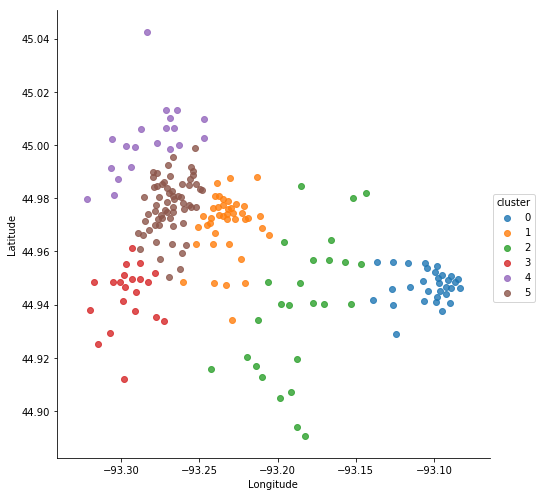

In [33]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)

## Intra/Trans-cluster travel
 * This can be split be (non-)membership too

In [34]:
# Build a data frame with start terminal as indices, end terminal as columns filled with zeros
travel_df = pd.DataFrame(columns = station_ids, index = station_ids).fillna(0)

In [35]:
start = rides_df['Start_id'].values
end = rides_df['End_id'].values

for x in range(len(rides_df['Start_id'].values)) :
    travel_df.loc[start[x], end[x]] += 1

In [36]:
from sklearn.preprocessing import normalize

travel_matrix = travel_df.values
normed_travel = normalize(travel_matrix, axis=1, norm='l1')

In [37]:
clus_array = six_nr_clusters.cluster.values
term_cluster_pair = {}
for x in range(len(station_ids)) :
    term_cluster_pair[station_ids[x]] = clus_array[x]

In [38]:
'''
Build this better using lambda mapping and dictionaries
'''
travel_to = pd.DataFrame(columns=['to_0', 'to_1', 'to_2', 'to_3', 'to_4', 'to_5'], \
                              index=station_ids).fillna(0)

for x in station_ids :
    if term_cluster_pair[x] == 0:
        travel_to['to_0'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 1:
        travel_to['to_1'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 2:
        travel_to['to_2'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 3:
        travel_to['to_3'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 4:
        travel_to['to_4'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 5:
        travel_to['to_5'] += (travel_df[x].values)

We're going to transpose the travel_matrix. This will give us instead of a data frame with start terminal as indices, end terminal as columns filled with zeros (from-to), a data frame with end terminals as indices and start terminals as columns (to-from).

The purpose of this is to show how the clusters interact with each other.

In [39]:
from_matrix = travel_matrix.transpose(1,0)

In [40]:
from_df = pd.DataFrame(from_matrix, columns=station_ids, index=station_ids)

In [41]:
'''
Build this better using lambda mapping and dictionaries
'''

travel_from = pd.DataFrame(columns=['from_0', 'from_1', 'from_2', 'from_3', 'from_4', 'from_5'], \
                              index=station_ids).fillna(0)

for x in station_ids :
    if term_cluster_pair[x] == 0:
        travel_from['from_0'] += (from_df[x].values)
    elif term_cluster_pair[x] == 1:
        travel_from['from_1'] += (from_df[x].values)
    elif term_cluster_pair[x] == 2:
        travel_from['from_2'] += (from_df[x].values)
    elif term_cluster_pair[x] == 3:
        travel_from['from_3'] += (from_df[x].values)
    elif term_cluster_pair[x] == 4:
        travel_from['from_4'] += (from_df[x].values)
    elif term_cluster_pair[x] == 5:
        travel_from['from_5'] += (from_df[x].values)

Build a super dataframe containing all the extra features we've created

In [42]:
six_nr_clusters = pd.merge(six_nr_clusters, travel_to, left_on='Terminal', right_index=True)
six_nr_clusters = pd.merge(six_nr_clusters, travel_from, left_on='Terminal', right_index=True)
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster,m_count,c_count,...,to_2,to_3,to_4,to_5,from_0,from_1,from_2,from_3,from_4,from_5
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,5,2878,5422,...,46,117,422,6664,3,1281,37,137,411,6669
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,1,960,618,...,249,98,3,279,4,1077,180,125,5,420
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,1,1330,386,...,111,31,40,332,1,1267,92,7,32,256
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,4,317,81,...,2,4,105,189,0,61,1,3,100,173
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,5,2574,1514,...,35,438,75,3377,1,136,54,321,90,3376


In [43]:
intra_to_summary = pd.DataFrame(columns=['clus0', 'clus1', 'clus2','clus3', 'clus4', 'clus5', 'pct_intra'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)]).fillna(0)

for x in np.unique(six_nr_clusters.cluster.values) :
    intra_to_summary.loc['Cluster_'+str(x)]['clus0'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_0'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus1'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_1'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus2'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_2'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus3'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_3'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus4'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_4'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus5'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_5'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['pct_intra'] = (intra_to_summary.loc['Cluster_'+str(x)]['clus'+str(x)]\
                                                               / intra_to_summary.loc['Cluster_'+str(x),:].values.sum()) *100

In [44]:
intra_from_summary = pd.DataFrame(columns=['clus0', 'clus1', 'clus2','clus3', 'clus4', 'clus5', 'pct_intra'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)]).fillna(0)

for x in np.unique(six_nr_clusters.cluster.values) :
    intra_from_summary.loc['Cluster_'+str(x)]['clus0'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_0'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus1'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_1'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus2'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_2'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus3'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_3'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus4'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_4'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus5'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_5'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['pct_intra'] = (intra_from_summary.loc['Cluster_'+str(x)]['clus'+str(x)]\
                                                               / intra_from_summary.loc['Cluster_'+str(x),:].values.sum()) *100

## Cluster Migration Summaries

In [45]:
print('To-From')
print(intra_to_summary,'\n')
print('From-To')
print(intra_from_summary)

To-From
           clus0   clus1  clus2  clus3  clus4   clus5  pct_intra
Cluster_0  19923     179   1681     32      6      89         90
Cluster_1    149  114372   4492   2860    944   24138         77
Cluster_2   1807    4027  20385    983     34    1226         71
Cluster_3     23    2519   1115  38637    336   12165         70
Cluster_4      7     807     49    353   3755    5476         35
Cluster_5    126   24175   1900  14293   6911  149929         75 

From-To
           clus0   clus1  clus2  clus3  clus4   clus5  pct_intra
Cluster_0  19923     149   1807     23      7     126         90
Cluster_1    179  114372   4027   2519    807   24175         78
Cluster_2   1681    4492  20385   1115     49    1900         68
Cluster_3     32    2860    983  38637    353   14293         67
Cluster_4      6     944     34    336   3755    6911         31
Cluster_5     89   24138   1226  12165   5476  149929         77


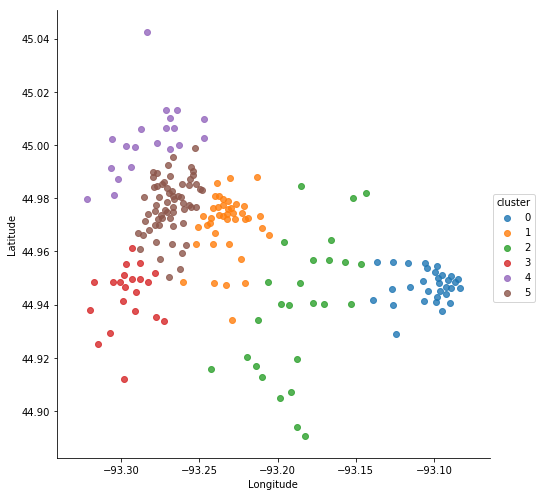

In [46]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)

In [47]:
# for later optimization
test = pd.DataFrame(intra_to_summary.values.T, \
             index=intra_to_summary.columns,\
            columns=['clus0', 'clus1', 'clus2','clus3', 'clus4', 'clus5']).fillna(0)

#test['pct_intra'] = test.append([(test.loc['clus'+str(x)]['clus'+str(x)]\
#                                / test.loc['clus'+str(x),:].values.sum()) *100\
#                                for x in range(6)])
test

,clus0,clus1,clus2,clus3,clus4,clus5
clus0,19923,149,1807,23,7,126
clus1,179,114372,4027,2519,807,24175
clus2,1681,4492,20385,1115,49,1900
clus3,32,2860,983,38637,353,14293
clus4,6,944,34,336,3755,6911
clus5,89,24138,1226,12165,5476,149929
pct_intra,90,77,71,70,35,75


## Matrix by station-station travel

In [48]:
from sklearn.preprocessing import normalize

normed_travel = normalize(travel_matrix, axis=1, norm='l1')

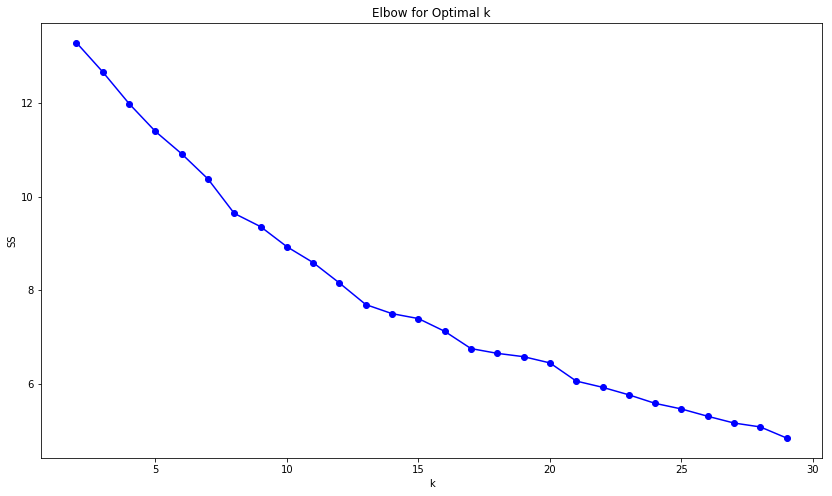

In [49]:
SS = []

# k means determine k
for k in range(2,30) :
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(normed_travel)

    SS.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(14,8))
plt.plot(range(2,30), SS, 'bo-')
plt.xlabel('k')
plt.ylabel('SS')
plt.title('Elbow for Optimal k')
plt.show()

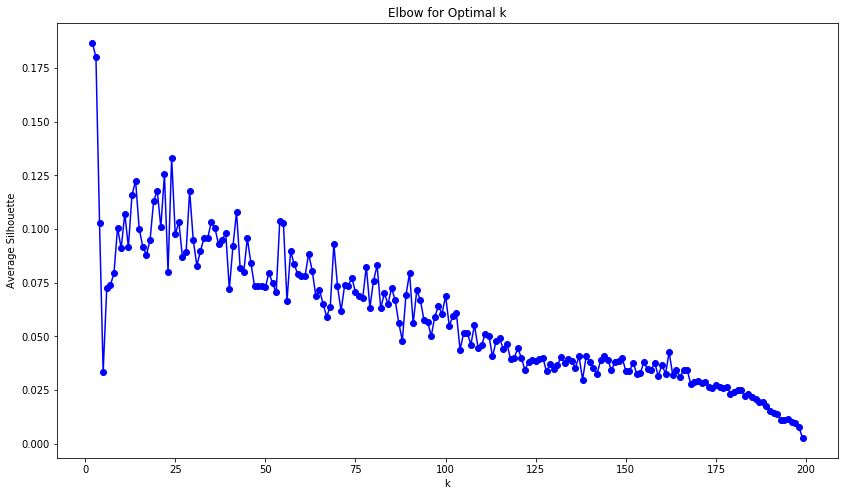

In [50]:
avg_sil = []

#    Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 10 clusters.
for k in range(2,200) :
    clusterer = KMeans(n_clusters=k, random_state=24).fit(normed_travel)
    cluster_labels = clusterer.labels_
    
#    For each k, calculate the average silhouette of observations (avg.sil).
    avg_sil.append(silhouette_score(normed_travel, cluster_labels))
    

#    Plot the curve of avg.sil according to the number of clusters k.
plt.figure(figsize=(14,8))
plt.plot(range(2,200), avg_sil, 'bo-')
plt.xlabel('k')
plt.ylabel('Average Silhouette')
plt.title('Elbow for Optimal k')
plt.show()
#    The location of the maximum is considered as the appropriate number of clusters.

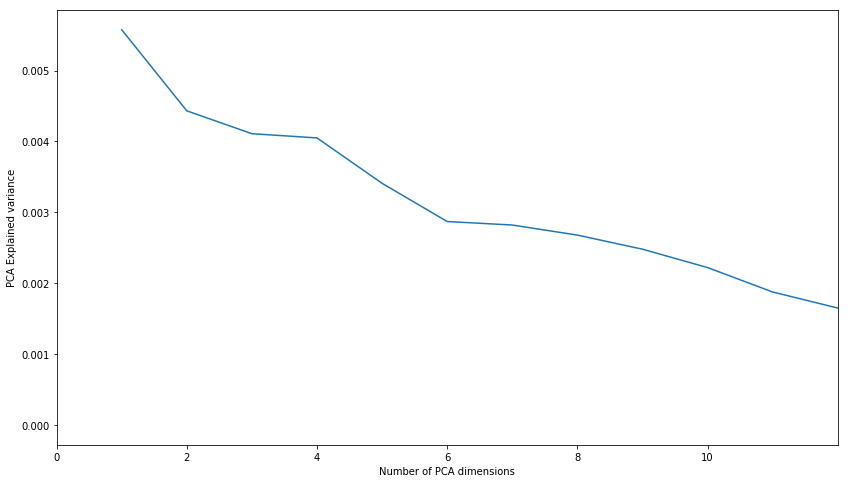

In [51]:
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(normed_travel)

plt.figure(figsize=[14,8])
plt.xlim(0,12)
plt.plot(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xticks(range(0,12,2))
plt.ylabel('PCA Explained variance')
plt.xlabel('Number of PCA dimensions')
plt.show()

We will also assume 6 & 25 dimensions for final clustering, 2 will be used for visualization

In [52]:
pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(normed_travel), columns=['x','y'], index=nr_station_2017.index)
pca_df = pd.DataFrame(nr_station_2017.Terminal).join(pca_df)
    # Joins terminal ID to pca_df containing x-y PCA components
print(pca_df.head())

   Terminal         x         y
0     30000 -0.049993 -0.031629
1     30001 -0.022566 -0.006934
2     30002 -0.035398 -0.062052
3     30003 -0.030759 -0.013581
4     30004 -0.042256  0.014602


## To-From cluster visualization

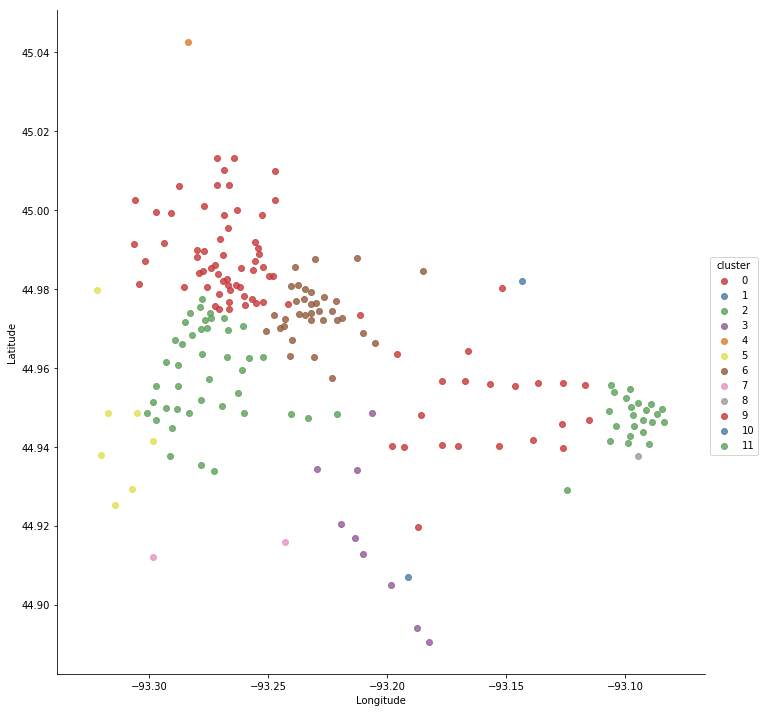

In [53]:
pca_df['cluster']= KMeans(n_clusters=12).fit(normed_travel).labels_
travel_cluster = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')
# Stations based on coordinates and clusters

palette = sns.color_palette("Set1", n_colors=12, desat=.7)
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=travel_cluster, fit_reg=False, palette=palette, size=10)

Using transposition we'll see if there is any difference in a to-from clustering

In [54]:
from_normed = normed_travel.transpose(1,0)

In [55]:
pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(from_normed), columns=['x','y'], index=nr_station_2017.index)
pca_df = pd.DataFrame(nr_station_2017.Terminal).join(pca_df)
    # Joins terminal ID to pca_df containing x-y PCA components
print(pca_df.head())

   Terminal         x         y
0     30000 -0.125314 -0.063304
1     30001 -0.016113 -0.002442
2     30002 -0.014622 -0.026503
3     30003 -0.005874 -0.000660
4     30004 -0.062267  0.022107


## From-To cluster visualization

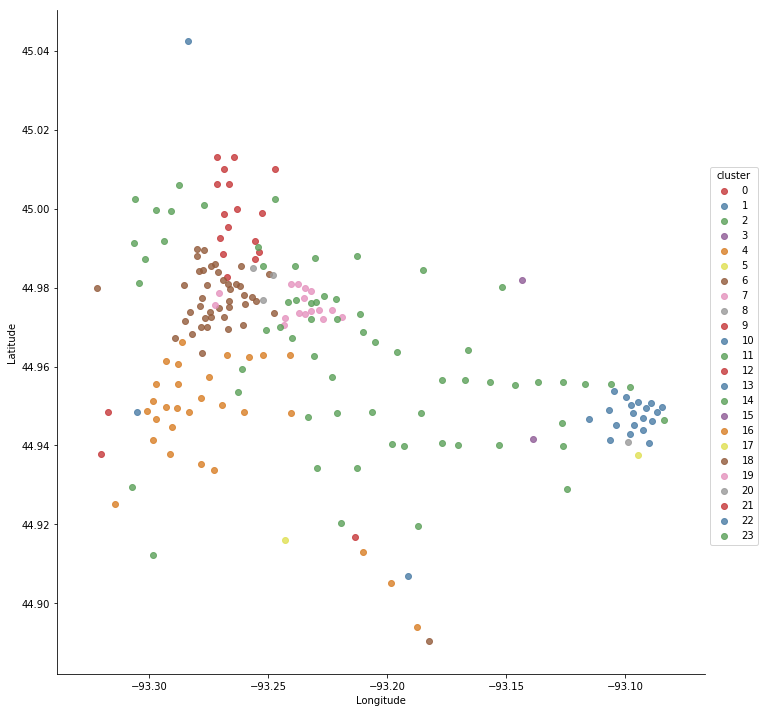

In [56]:
pca_df['cluster']= KMeans(n_clusters=24).fit(from_normed).labels_
travel_cluster = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')
# Stations based on coordinates and clusters

palette = sns.color_palette("Set1", n_colors=12, desat=.7)
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=travel_cluster, fit_reg=False, palette=palette, size=10)

In [57]:
# build cluster centers
pca = pd.DataFrame(PCA(n_components=2).fit_transform(from_normed), columns=['x','y'], index=nr_station_2017.index)
cluster_centers = KMeans(n_clusters=12).fit(pca).cluster_centers_ # Retrieves cluster center
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))